# Model MobileNetV2 untuk Capstone Project: **Recyclepedia**
Datasets : https://drive.google.com/drive/folders/1BkxkYTDxBIg4mHoA8BkM4UV0ff-R8kmt?usp=drive_link

## **Pre - Processing Data**

Import Library

In [22]:
import os
import shutil
from shutil import copyfile
from sklearn.model_selection import train_test_split
import gdown
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


Import Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
import os
os.chdir('/content/drive/MyDrive/Garbage classification')

In [24]:
# Path ke dataset di Google Drive
base_dir = ('/content/drive/MyDrive/Garbage classification')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Pastikan direktori untuk setiap kelas
classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic']

for class_name in classes:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)


In [25]:
import os

# Tampilkan daftar file di direktori ekstraksi
base_dir = ('/content/drive/MyDrive/Garbage classification')
os.listdir(base_dir)


['paper',
 'cardboard',
 'glass',
 'plastic',
 'metal',
 'train',
 'test',
 'validation',
 'best_model_mobilenetv2.h5',
 'model_mobilenetv2.h5']

**Train Test Validation**

Membagi Dataset Menjadi Train, Validation, dan Test

In [26]:
import os
from shutil import copyfile
from sklearn.model_selection import train_test_split

def split_data(source_dir, train_dir, val_dir, test_dir, train_split=0.6, val_split=0.2, test_split=0.2):
    filenames = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]
    train_filenames, temp_filenames = train_test_split(filenames, test_size=1-train_split, random_state=42)
    val_filenames, test_filenames = train_test_split(temp_filenames, test_size=test_split/(test_split + val_split), random_state=42)

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for filename in train_filenames:
        src = os.path.join(source_dir, filename)
        dest = os.path.join(train_dir, filename)
        copyfile(src, dest)

    for filename in val_filenames:
        src = os.path.join(source_dir, filename)
        dest = os.path.join(val_dir, filename)
        copyfile(src, dest)

    for filename in test_filenames:
        src = os.path.join(source_dir, filename)
        dest = os.path.join(test_dir, filename)
        copyfile(src, dest)

for class_name in classes:
    source_dir = os.path.join(base_dir, class_name)
    train_class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(validation_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)

    split_data(source_dir, train_class_dir, val_class_dir, test_class_dir)

KeyboardInterrupt: 

In [28]:
train_dir = ('/content/drive/MyDrive/Garbage classification/train')
val_dir = ('/content/drive/MyDrive/Garbage classification/validation')
test_dir = ('/content/drive/MyDrive/Garbage classification/test')

In [29]:
#cardboard, glass, metal, paper, plastic
import os
folder_path = ('/content/drive/MyDrive/Garbage classification/train/cardboard')
folder_path = ('/content/drive/MyDrive/Garbage classification/train/glass')
folder_path = ('/content/drive/MyDrive/Garbage classification/train/metal')
folder_path = ('/content/drive/MyDrive/Garbage classification/train/paper')
folder_path = ('/content/drive/MyDrive/Garbage classification/train/plastic')
test = os.listdir(folder_path)
# for fichier in test:
#     if not(fichier.endswith(".jpg")):
#         os.remove(os.path.join(folder_path, fichier))

In [30]:
#cek label
from pathlib import Path
train_dir = Path('/content/drive/MyDrive/Garbage classification/train')
test_dir = Path('/content/drive/MyDrive/Garbage classification/test')
val_dir = Path('/content/drive/MyDrive/Garbage classification/validation')

# Mendapatkan daftar filepaths dan labels untuk dataset dan data uji
# Get filepaths and labels
filepaths = list(train_dir.glob(r'**/*.jpg')) + list(train_dir.glob(r'**/*.JPG')) + list(train_dir.glob(r'**/*.jpeg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Get filepaths and labels data validation
filepaths_val = list(val_dir.glob(r'**/*.jpg')) + list(val_dir.glob(r'**/*.JPG')) + list(val_dir.glob(r'**/*.jpeg'))
labels_val = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths_val))

# Get filepaths and labels data testing
filepaths_test = list(test_dir.glob(r'**/*.jpg')) + list(test_dir.glob(r'**/*.JPG')) + list(test_dir.glob(r'**/*.jpeg'))
labels_test = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths_test))

### **Augmentasi dan Preprocessing Gambar**

Menampilkan Gambar dari dataset train

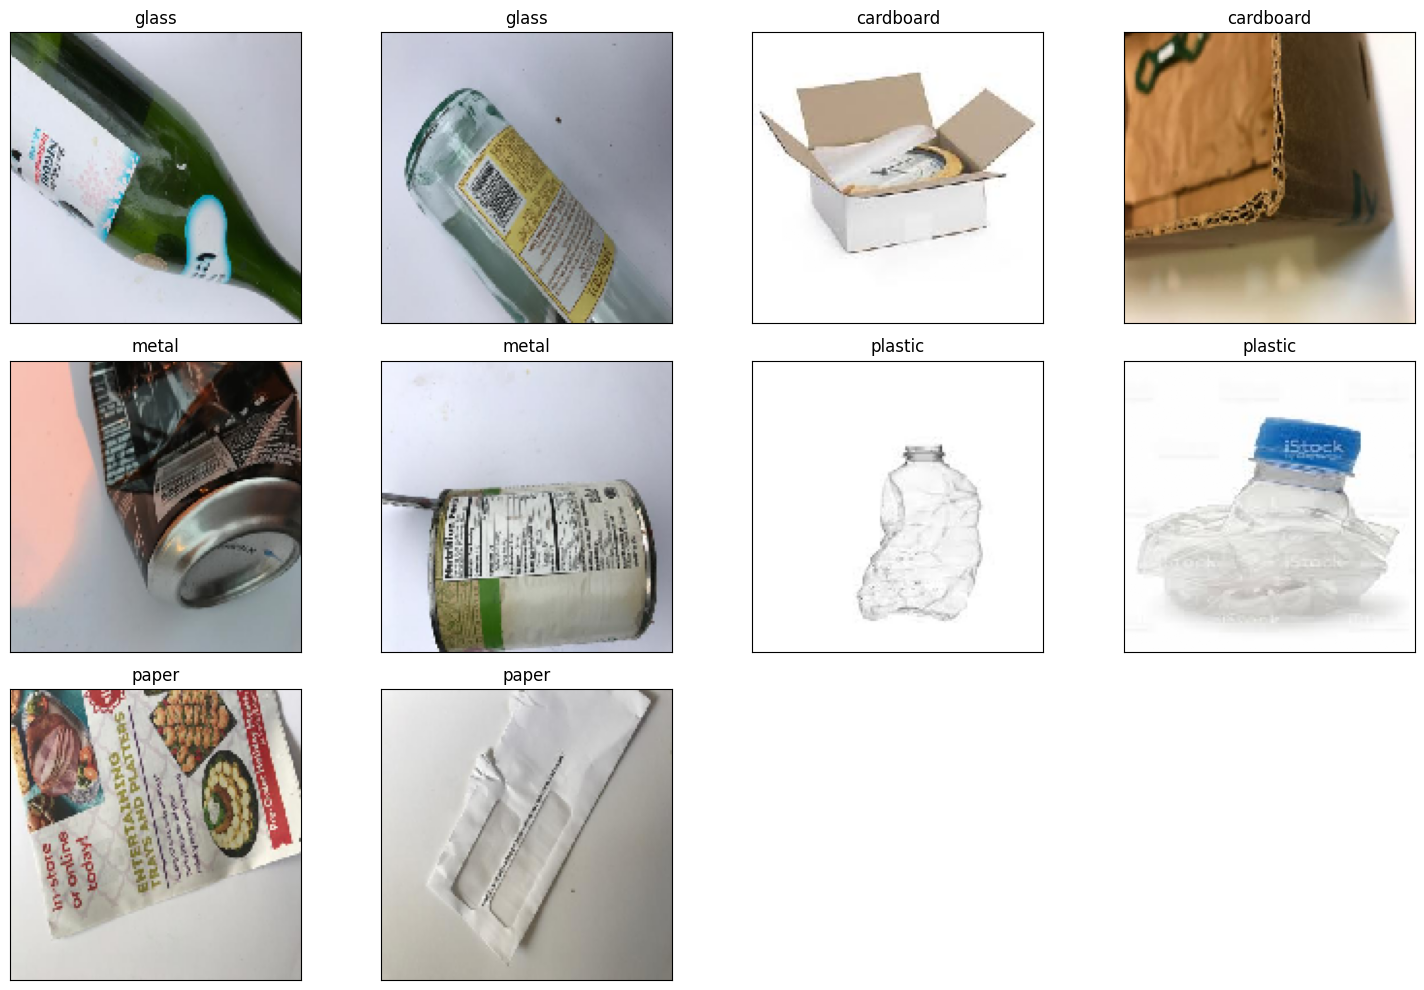

In [31]:
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path ke dataset
train_dir = '/content/drive/MyDrive/Garbage classification/train'

# Fungsi untuk menampilkan gambar dari setiap label
def display_sample_images(train_dir, num_images=12):
    class_names = os.listdir(train_dir)
    num_classes = len(class_names)
    num_cols = 4
    num_rows = (num_images + num_cols - 1) // num_cols  # Menghitung jumlah baris yang diperlukan

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10), subplot_kw={'xticks': [], 'yticks': []})
    axes = axes.flatten()

    img_idx = 0
    for class_name in class_names:
        class_dir = os.path.join(train_dir, class_name)
        img_files = os.listdir(class_dir)
        num_samples = min(len(img_files), num_images // num_classes)

        for img_file in random.sample(img_files, num_samples):
            img_path = os.path.join(class_dir, img_file)
            img = load_img(img_path, target_size=(150, 150))
            img_array = img_to_array(img) / 255.0

            ax = axes[img_idx]
            ax.imshow(img_array)
            ax.set_title(class_name)
            img_idx += 1
            if img_idx >= num_images:
                break
        if img_idx >= num_images:
            break

    # Jika ada subplot yang kosong, hapus subplot tersebut
    for j in range(img_idx, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Panggil fungsi untuk menampilkan gambar
display_sample_images(train_dir, num_images=12)


Augmentasi ImageDataGenerator

In [32]:
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directories
train_dir = Path('/content/drive/MyDrive/Garbage classification/train')
test_dir = Path('/content/drive/MyDrive/Garbage classification/test')
val_dir = Path('/content/drive/MyDrive/Garbage classification/validation')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1244 images belonging to 5 classes.
Found 415 images belonging to 5 classes.
Found 418 images belonging to 5 classes.


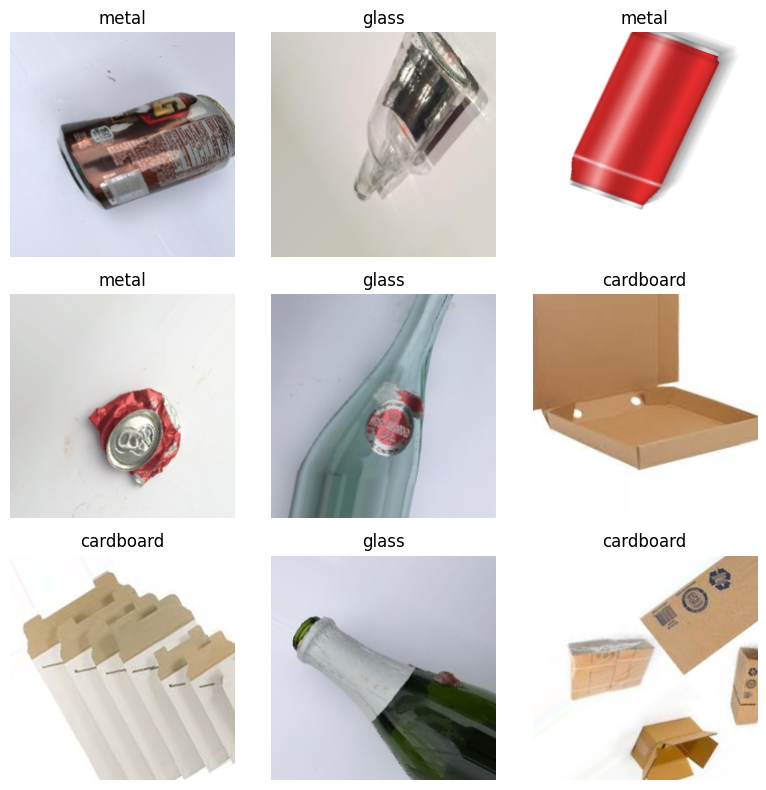

In [33]:
import matplotlib.pyplot as plt

# Ambil satu batch gambar dari generator
augmented_images, labels = next(train_generator)

# Menampilkan beberapa contoh gambar yang telah diaugmentasi
num_images = 9
plt.figure(figsize=(8, 8))

# Generate a batch of augmented images
for i in range(num_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    label_index = labels[i].argmax()  # Get the index of the maximum value (1) in the one-hot encoded label
    label_name = list(train_generator.class_indices.keys())[label_index]  # Get the class name using the index
    plt.title(label_name)
    plt.axis('off')

plt.tight_layout()
plt.show()


## **Membangun Model | CNN**

Import Library

In [34]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

###**Model MobileNetV2**

In [46]:
import pickle
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np

# Define the number of classes
num_classes = train_generator.num_classes

# Extract target labels from the generator
train_labels = train_generator.classes

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = dict(enumerate(class_weights))

# Build model
def build_model(num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Define custom callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('val_accuracy') is not None:
            if logs.get('accuracy') > 0.96 and logs.get('val_accuracy') > 0.96:
                print("\nReached 96% accuracy so cancelling training!")
                self.model.stop_training = True

# Build the model
model = build_model(num_classes)

# Define callbacks
checkpoint = ModelCheckpoint("best_model_mobilenetv2.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
callbacks = [checkpoint, early_stopping, reduce_lr, myCallback()]

# Train the model with class weights
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

# Save training history
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

# Save the model
model.save('model_mobilenetv2.h5')


Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2877 - loss: 1.7458
Epoch 1: val_accuracy improved from -inf to 0.70843, saving model to best_model_mobilenetv2.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.2906 - loss: 1.7387 - val_accuracy: 0.7084 - val_loss: 0.8586 - learning_rate: 1.0000e-04
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6145 - loss: 0.9505
Epoch 2: val_accuracy improved from 0.70843 to 0.78795, saving model to best_model_mobilenetv2.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.6151 - loss: 0.9495 - val_accuracy: 0.7880 - val_loss: 0.6359 - learning_rate: 1.0000e-04
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7044 - loss: 0.7539
Epoch 3: val_accuracy improved from 0.78795 to 0.82410, saving model to best_model_mobilenetv2.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.7045 - loss: 0.7537 - val_accuracy: 0.8241 - val_loss: 0.5454 - learning_rate: 1.0000e-04
Epoch 4/50
39/39 ━━━━

Test Accuracy: 0.9138755798339844


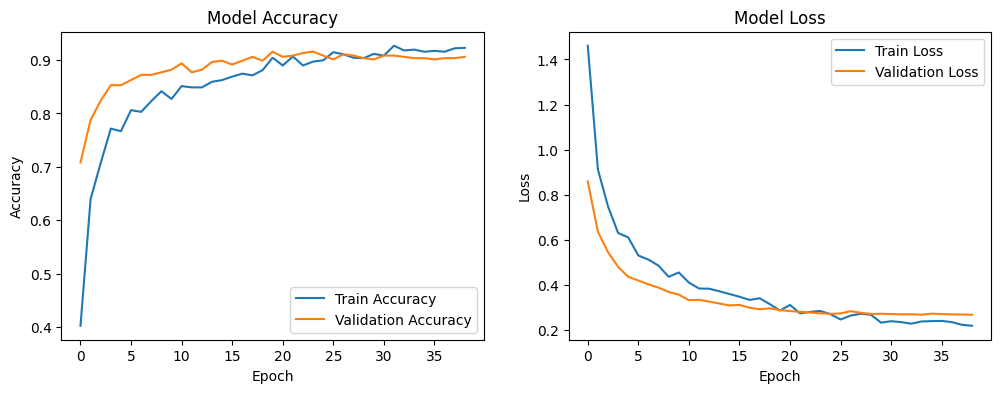

In [47]:
# Plotting the accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the training history
plot_training_history(history)

### **Evaluasi Model**

Periksa bentuk data yang dihasilkan oleh generator

In [51]:
# Periksa jumlah kelas dalam train, validation, dan test generator
print(f"Number of classes in train generator: {train_generator.num_classes}")
print(f"Number of classes in validation generator: {val_generator.num_classes}")
print(f"Number of classes in test generator: {test_generator.num_classes}")

# Ambil satu batch dari train generator dan periksa bentuknya
sample_batch = next(train_generator)
print(f"Shape of image batch: {sample_batch[0].shape}")
print(f"Shape of label batch: {sample_batch[1].shape}")

# Ambil satu batch dari test generator dan periksa bentuknya
sample_batch_test = next(test_generator)
print(f"Shape of image batch (test): {sample_batch_test[0].shape}")
print(f"Shape of label batch (test): {sample_batch_test[1].shape}")


Number of classes in train generator: 5
Number of classes in validation generator: 5
Number of classes in test generator: 5
Shape of image batch: (32, 224, 224, 3)
Shape of label batch: (32, 5)
Shape of image batch (test): (32, 224, 224, 3)
Shape of label batch (test): (32, 5)


####Classication Report

In [48]:
import numpy as np
from sklearn.metrics import classification_report

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

# Generate classification report
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)


14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9372 - loss: 0.2132
Test Accuracy: 0.9138755798339844
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step
              precision    recall  f1-score   support

   cardboard       0.99      0.98      0.98        86
       glass       0.90      0.90      0.90        83
       metal       0.86      0.89      0.88        83
       paper       0.92      0.93      0.92        82
     plastic       0.90      0.87      0.88        84

    accuracy                           0.91       418
   macro avg       0.91      0.91      0.91       418
weighted avg       0.91      0.91      0.91       418



In [49]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict the classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Generate classification report
report = classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys()))
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print(conf_matrix)


14/14 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step
              precision    recall  f1-score   support

   cardboard       0.99      0.98      0.98        86
       glass       0.90      0.90      0.90        83
       metal       0.86      0.89      0.88        83
       paper       0.92      0.93      0.92        82
     plastic       0.90      0.87      0.88        84

    accuracy                           0.91       418
   macro avg       0.91      0.91      0.91       418
weighted avg       0.91      0.91      0.91       418

[[84  0  0  2  0]
 [ 0 75  4  1  3]
 [ 0  4 74  2  3]
 [ 1  1  2 76  2]
 [ 0  3  6  2 73]]


####**Confusion Matrix**

14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step


<Figure size 700x700 with 0 Axes>

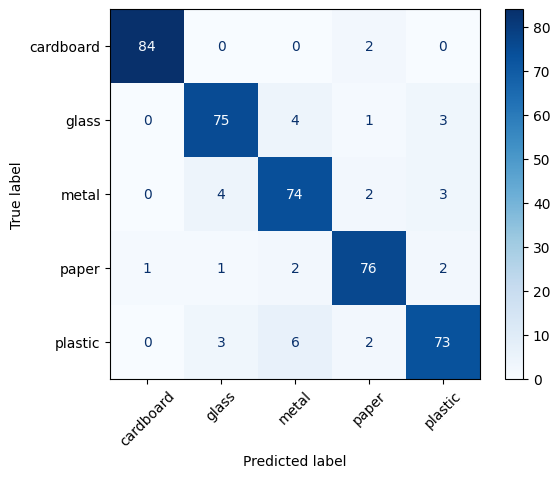

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Pastikan model telah diinisialisasi dan dilatih
# test_generator sudah diinisialisasi sebelumnya

# Lakukan prediksi pada data pengujian
test_generator.reset()  # Reset the generator to make predictions from the start
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1, verbose=1)

# Ambil label sebenarnya dari generator
true_labels = test_generator.classes

# Ambil label prediksi
predicted_labels = np.argmax(predictions, axis=1)

# Buat confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(test_generator.class_indices.keys()))

# Plot confusion matrix
plt.figure(figsize=(7,7))
cmd.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.show()


###**Prediksi menggunakan test_dir**

14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step


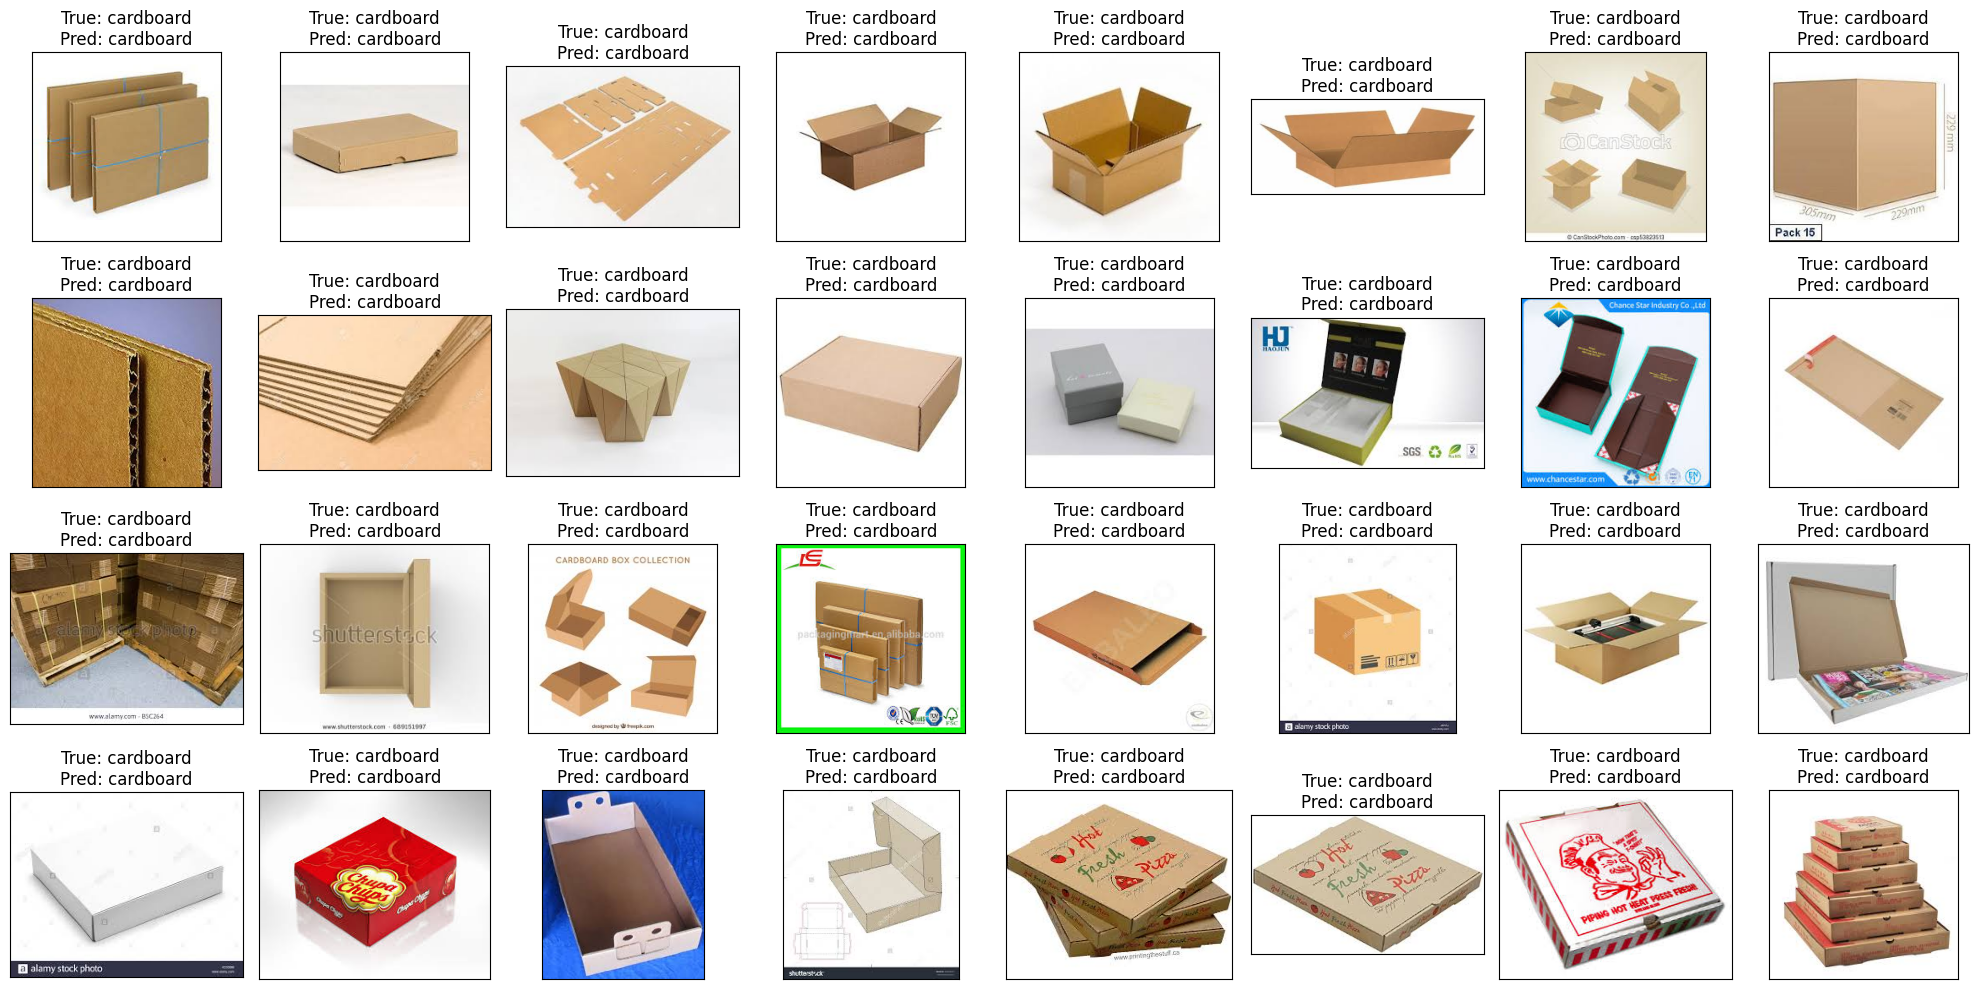

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Pastikan model telah diinisialisasi dan dilatih
# test_generator sudah diinisialisasi sebelumnya

# Lakukan prediksi pada data pengujian
test_generator.reset()  # Reset the generator to make predictions from the start
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1, verbose=1)

# Ambil label sebenarnya dari generator
true_labels = test_generator.classes

# Ambil label prediksi
predicted_labels = np.argmax(predictions, axis=1)

# Ambil beberapa gambar dari dataset pengujian
test_generator.reset()
images, _ = next(test_generator)
image_paths = test_generator.filepaths[:32]  # Misalnya, ambil 32 gambar pertama

# Konversi dict_keys ke list untuk indexing
class_names = list(test_generator.class_indices.keys())

# Visualisasikan gambar dengan label sebenarnya dan prediksi
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(20, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = plt.imread(image_paths[i])
    ax.imshow(img)
    true_label = class_names[true_labels[i]]
    predicted_label = class_names[predicted_labels[i]]
    ax.set_title(f"True: {true_label}\nPred: {predicted_label}")

plt.tight_layout()
plt.show()


### **Uji Coba Model**

###**Testing Input Gambar**

Saving Untitledq.jpeg to Untitledq (1).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


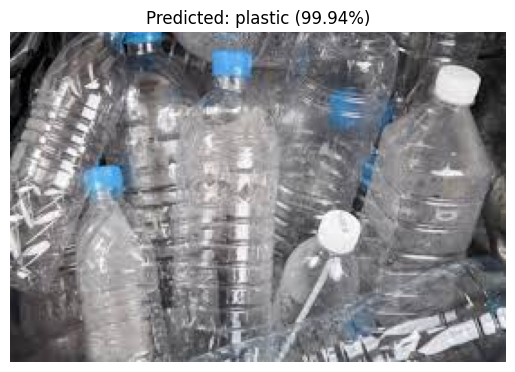

In [61]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import json

# Load the trained model
model = load_model('/content/drive/MyDrive/Garbage classification/model_mobilenetv2.h5')

# Define the class indices (you can get this from your train_generator)
# Example: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
class_indices = train_generator.class_indices

# Function to preprocess and predict the class of an image
def predict_image(img_path, model, class_indices):
    # Load the image
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocess the image
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Rescale to [0, 1]

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = list(class_indices.keys())[list(class_indices.values()).index(predicted_class_index)]

    return predicted_class, predictions

# Function to display the image and the prediction
def display_prediction(img_path, predicted_class, predictions):
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({np.max(predictions)*100:.2f}%)")
    plt.show()

# Upload an image from the user
uploaded = files.upload()

for img_path in uploaded.keys():
    predicted_class, predictions = predict_image(img_path, model, class_indices)
    display_prediction(img_path, predicted_class, predictions)


### **Deploy JSON dan BIN**

In [54]:
# Save the model
model.save('model_mobilenetv2.h5')

In [55]:
saved_model_path = "./model_mobilenetv2.h5"

# YOUR CODE HERE
model.save(saved_model_path)

In [56]:
# EXERCISE: Use the tensorflow.js converter to convert the saved Keras model into JSON format.
# !pip install tensorflowjs

# Uncomment the next line if you want to clear previously generated .bin and json files before running the converter
# !rm *.bin Model2.json submission.zip

!tensorflowjs_converter --input_format=keras {saved_model_path} ./
# YOUR CODE HERE

2024-06-06 02:53:22.027402: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
failed to lookup keras version from the file,
    this is likely a weight only file


In [57]:
# compress necessary files for grading
!zip Model.zip *.bin Garbagemodel.json

	zip warning: name not matched: Garbagemodel.json
  adding: group1-shard1of3.bin (deflated 7%)
  adding: group1-shard2of3.bin (deflated 7%)
  adding: group1-shard3of3.bin (deflated 7%)


## **NB: Cek Jumlah Data disetiap class**

Jumlah data asli

Jumlah gambar di setiap kelas pada direktori utama:
{'cardboard': 426, 'glass': 411, 'metal': 414, 'paper': 410, 'plastic': 416}


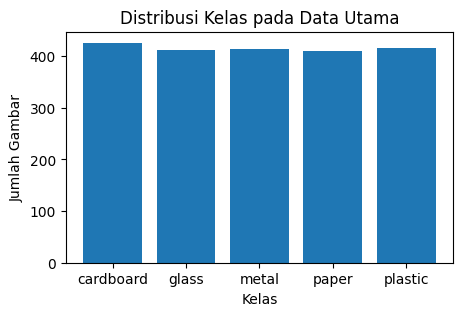

In [62]:
import os
import matplotlib.pyplot as plt

# Direktori untuk dataset
base_dir = '/content/drive/MyDrive/Garbage classification'

# Daftar kelas
classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic']

def count_images(directory, classes):
    class_counts = {}
    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

# Hitung jumlah gambar di setiap kelas pada direktori utama
class_counts = count_images(base_dir, classes)

print("Jumlah gambar di setiap kelas pada direktori utama:")
print(class_counts)

# Visualisasi distribusi kelas
def plot_class_distribution(counts, title):
    plt.figure(figsize=(5,3))
    plt.bar(counts.keys(), counts.values())
    plt.title(title)
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Gambar')
    plt.show()

plot_class_distribution(class_counts, 'Distribusi Kelas pada Data Utama')


Jumlah data yang sudah di split

In [63]:
import os

# Direktori untuk dataset
base_dir = '/content/drive/MyDrive/Garbage classification'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Daftar kelas
classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic']

def count_images(directory, classes):
    class_counts = {}
    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

# Hitung jumlah gambar di setiap kelas untuk train, validation, dan test directories
train_counts = count_images(train_dir, classes)
val_counts = count_images(validation_dir, classes)
test_counts = count_images(test_dir, classes)

print("Jumlah gambar di setiap kelas pada train directory:")
print(train_counts)
print("\nJumlah gambar di setiap kelas pada validation directory:")
print(val_counts)
print("\nJumlah gambar di setiap kelas pada test directory:")
print(test_counts)


Jumlah gambar di setiap kelas pada train directory:
{'cardboard': 255, 'glass': 246, 'metal': 248, 'paper': 246, 'plastic': 249}

Jumlah gambar di setiap kelas pada validation directory:
{'cardboard': 85, 'glass': 82, 'metal': 83, 'paper': 82, 'plastic': 83}

Jumlah gambar di setiap kelas pada test directory:
{'cardboard': 86, 'glass': 83, 'metal': 83, 'paper': 82, 'plastic': 84}
